In [19]:
import pymc as pm
import matplotlib.pyplot as plt
%matplotlib inline
from rpy2.robjects import r
import numpy as np

# Experiment Set Up

First let's consider an experiment where we're trying to compare the conversion rate between control (do nothing) and treatment (sales call).

Suppose that the control has a conversion rate of 10% and treatment is 5% better than control.

In [90]:
true_c = 0.05
true_delta = 0.05
true_t = true_c * (1+ true_delta)

In [91]:
true_t

0.052500000000000005

## Frequentist Setup

In the frequentist set up, we would start off with a power analysis. How many samples do we need in order to achieve 80% power to detect a 5% difference in conversion rates between treatment and control with 95% confidence?

In [79]:
r.assign('remotep1', true_c)
r.assign('remotep2', true_t)

bucket_size = r('round(power.prop.test(p1 = remotep1, p2 = remotep2, sig.level=.05, power=0.80)$n)')[0]
sample_size = 2*bucket_size
sample_size

244246.0

In [80]:
n_t = bucket_size
n_c = bucket_size

observations_t = pm.rbernoulli(true_t, n_t)
observations_c = pm.rbernoulli(true_c, n_c)

print(observations_t.mean())
print(observations_c.mean())

0.0533724196097
0.0496712331011


## Bayesian A/B

In [81]:
conv_t = pm.Uniform("conv_t", 0, 1)
conv_c = pm.Uniform("conv_c", 0, 1)

obs_t = pm.Bernoulli("obs_t", conv_t, 
                    value = observations_t,
                    observed = True)

obs_c = pm.Bernoulli("obs_t", conv_c, 
                    value = observations_c,
                    observed = True)

@pm.deterministic
def delta(conv_t = conv_t, conv_c = conv_c):
    return (conv_t - conv_c) / conv_c

mcmc = pm.MCMC([conv_t, conv_c, obs_t, obs_c, delta])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 37.5 sec

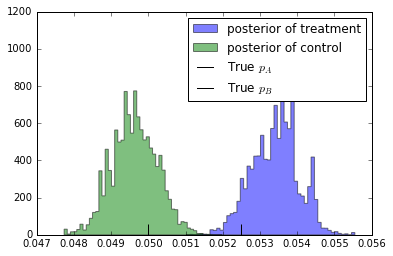

In [82]:
conv_t_samples = mcmc.trace("conv_t")[:]
conv_c_samples = mcmc.trace("conv_c")[:]
delta_samples = mcmc.trace("delta")[:]

plt.hist(conv_t_samples, histtype="stepfilled", alpha = 0.5, 
        bins = 50, label = "posterior of treatment", normed = True);
plt.hist(conv_c_samples, histtype="stepfilled", alpha = 0.5, 
        bins = 50, label = "posterior of control", normed = True);
plt.vlines(true_t, 0 , 60, label = "True $p_A$");
plt.vlines(true_c, 0 , 60, label = "True $p_B$");
plt.legend();

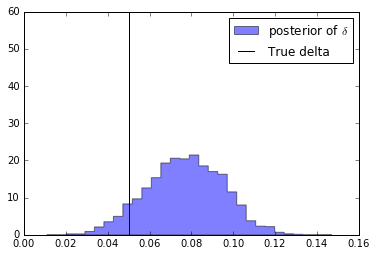

In [83]:
plt.hist(delta_samples, histtype="stepfilled", alpha = 0.5, 
        bins = 30, label = "posterior of $\delta$", 
         normed = True);
plt.vlines(true_delta, 0 , 60, label = "True delta");
plt.legend();

Probability that treatment is better than control:

In [84]:
(delta_samples > 0).mean()

1.0

30th percentile of lift:

In [85]:
np.percentile(delta_samples, 30)

0.067346181213380304

### Expected Revenues

Suppose that the treatment (sales call) costs \$50 per customer and that each conversion is worth \$500 in LTV. Let's calculate expected revenues.

In [86]:
cost_per_customer = 2
rev_per_customer = 1000
revenue_c = (rev_per_customer*conv_c_samples)
revenue_t = (rev_per_customer*conv_t_samples - cost_per_customer)

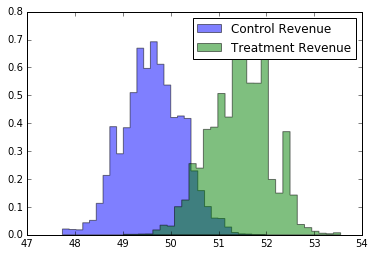

In [87]:
plt.hist(revenue_c, histtype="stepfilled", alpha = 0.5, 
        bins = 30, label = "Control Revenue", normed = True);
plt.hist(revenue_t, histtype="stepfilled", alpha = 0.5, 
        bins = 30, label = "Treatment Revenue", normed = True);
plt.legend();

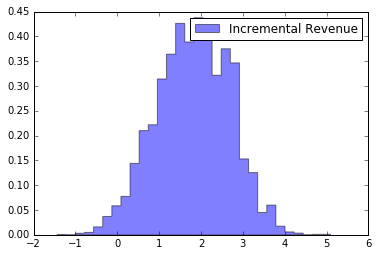

In [88]:
plt.hist(revenue_t - revenue_c, histtype="stepfilled", alpha = 0.5, 
        bins = 30, label = "Incremental Revenue", normed = True);
plt.legend();

In [89]:
print("Probability of losing money: %0.3f" % ((revenue_t - revenue_c)<0).mean())

Probability of losing money: 0.021
